In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 30 12:32:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re


In [8]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/X11967"
tsvData = os.path.join(dataDir,"WoSDataset_11967.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(11967, 4)


In [9]:
print(tsvData[0:10])

[['2' 'Psychology'
  ' interview anxiety interview performance person perception job interview        '
  'the aim of this study was to investigate a the behavioral cues that are displayed by and trait judgments formed about anxious interviewees and b why anxious interviewees receive lower interview performance ratings the behavioral expression of interview anxiety model was created as a conceptual framework to explore these relations we videotaped and transcribed mock job interviews obtained ratings of interview anxiety and interview performance and trained raters to assess several verbal and nonverbal cues and trait judgments the results indicated that few behavioral cues but several traits were related to interviewee and interviewer ratings of interview anxiety two factors emerged from our factor analysis on the trait judgmentsassertiveness and interpersonal warmth mediation analyses were performed and indicated that assertiveness and interpersonal warmth mediated the relation betwe

In [10]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [11]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1499 2107 1132 1925 1617 1959 1728]


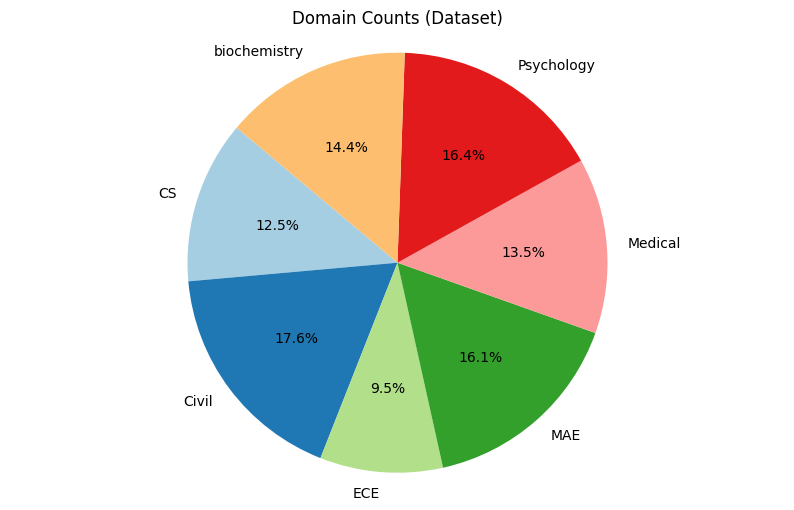

The domain CS has 1499 records in the dataset.
The domain Civil has 2107 records in the dataset.
The domain ECE has 1132 records in the dataset.
The domain MAE has 1925 records in the dataset.
The domain Medical has 1617 records in the dataset.
The domain Psychology has 1959 records in the dataset.
The domain biochemistry has 1728 records in the dataset.


In [12]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [13]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  11967
Shape of abstracts:  (11967,)
['great part of human communication is carried out nonverbally all this information is lost in mobile text messaging this work describes an attempt to augment text chatting in mobile phones by adding automatically detected facial expression reactions to conversations these expressions are detected using known image processing techniques known related work concerning the investigation of nonverbal communication through text messaging are considered and distinguished from the present solution the conception and implementation of a mobile phone application with the debated feature is described and user studies are narrated finally context of application conclusions and future work are also discussed'
 'based on logical ghz states and logical bell states two robust quantum key agreement protocols are proposed which can be immune to the collectivedephasing noise and the collectiverotation noise respectively the delayed measurement te

In [14]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load BioBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

(9573, 4)
(2394, 4)
(9573, 4)
(2394, 4)
(479, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [15]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  9573
Shape of abstracts:  (9573,)
Number of keywords:  9573
Shape of keywords:  (9573,)
Number of domains:  9573
Shape of domains:  (9573,)
Number of labels:  9573
Shape of labels:  (9573,)
['objective individuals with schizophrenia demonstrate cognitive social cognitive and motivational deficits that contribute to impairment in realworld functioning in the current study we investigated the effects of supplementing computerized neurocognitive training with social cognitive exercises as compared with neurocognitive training alone method in this ongoing doubleblind randomized controlled trial of 111 participants with psychosis we compare the effects of supplementing intensive targeted cognitive training with social cognitive training exercises tct  sct with the effects of targeted cognitive training alone tctonly participants were assessed on cognition symptoms functional capacity and functional outcomes as well as social cognition and measures related to reward pro

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1183 1691  895 1556 1303 1580 1365]


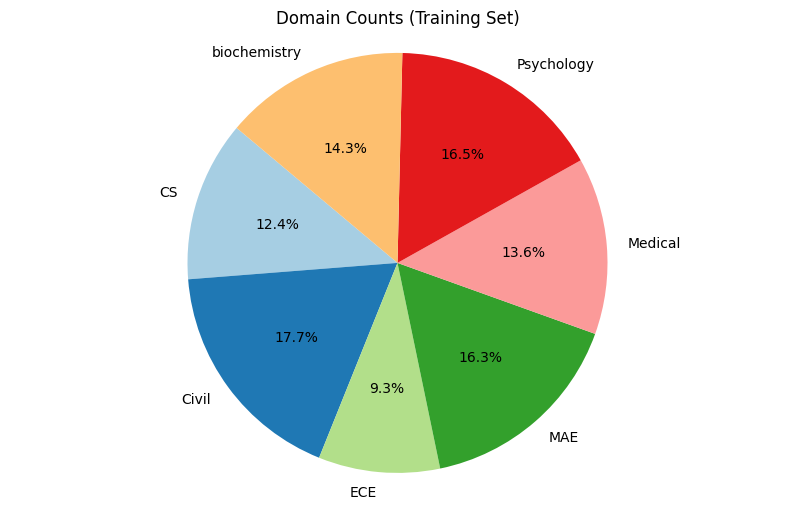

The domain CS has 1183 records in the training set.
The domain Civil has 1691 records in the training set.
The domain ECE has 895 records in the training set.
The domain MAE has 1556 records in the training set.
The domain Medical has 1303 records in the training set.
The domain Psychology has 1580 records in the training set.
The domain biochemistry has 1365 records in the training set.


In [16]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [17]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  2394
Shape of abstracts:  (2394,)
Number of keywords:  2394
Shape of keywords:  (2394,)
Number of domains:  2394
Shape of domains:  (2394,)
Number of labels:  2394
Shape of labels:  (2394,)
['in this study cluster analysis ca and discriminant analysis da were used to assess the water quality and evaluate its spatial and temporal variations in south florida for this purpose 15 years 20002014 data set of 12 water quality variables covering 16 monitoring stations and about 35000 observations were used agglomerative hierarchical ca grouped 16 monitoring sites into three groups low pollution moderate pollution and high pollution based on their similarity of water quality characteristics da as an important data reduction method and ca were used to assess the water pollution status and analysis of its spatiotemporal variation it was found by the stepwise da that five variables chia do tkn tp and water temperature were the most important discriminating water quality param

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [316 416 237 369 314 379 363]


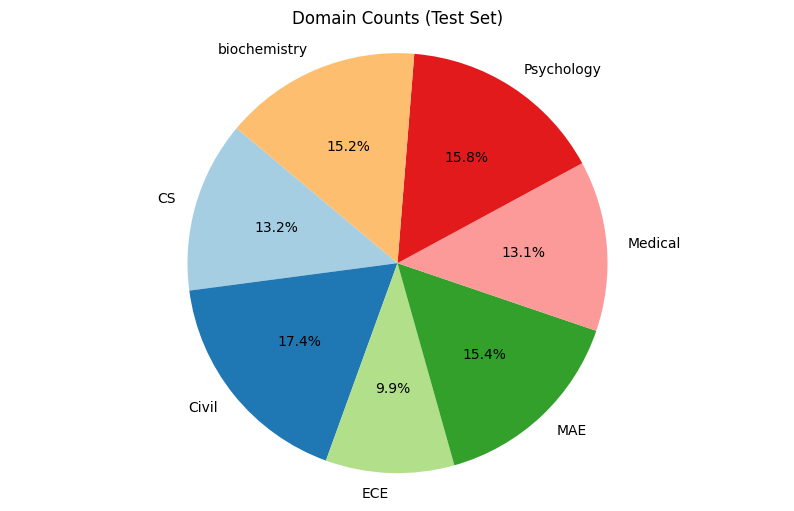

The domain CS has 316 records in the test set.
The domain Civil has 416 records in the test set.
The domain ECE has 237 records in the test set.
The domain MAE has 369 records in the test set.
The domain Medical has 314 records in the test set.
The domain Psychology has 379 records in the test set.
The domain biochemistry has 363 records in the test set.


In [18]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [19]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  479
Shape of abstracts:  (479,)
Number of keywords:  479
Shape of keywords:  (479,)
Number of domains:  479
Shape of domains:  (479,)
Number of labels:  479
Shape of labels:  (479,)
['nowadays elders often find it difficult to keep track of their cognitive and functional abilities required for remaining independent in their homes ambient assisted living aal are the ambient intelligence based technologies for the support of daily activities to elders traditional rehabilitation is an example of a common activity elders may require and that usually implies they move to the rehabilitation clinics which is the main reason for treatment discontinuation telerehabilitation is a solution that not only may help elders but also their family members and health professionals to monitor elders treatment the purpose of this paper is to present a telerehabilitation system that uses the motiontracking sensor of the kinect to allow the elderly users natural interaction combined wit

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [70 70 57 68 71 78 65]


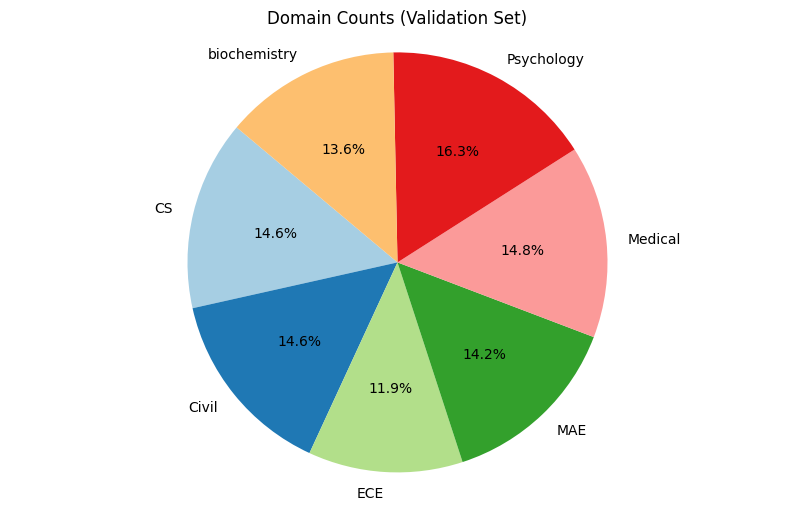

The domain CS has 70 records in the vaidation set.
The domain Civil has 70 records in the vaidation set.
The domain ECE has 57 records in the vaidation set.
The domain MAE has 68 records in the vaidation set.
The domain Medical has 71 records in the vaidation set.
The domain Psychology has 78 records in the vaidation set.
The domain biochemistry has 65 records in the vaidation set.


In [20]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [21]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstracts
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [22]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(9573, 4)
(2394, 4)
(479, 4)


In [23]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  9573
Label length  479
Label length  2394


In [24]:
# Load BioBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [25]:
model.config

BertConfig {
  "_name_or_path": "dmis-lab/biobert-base-cased-v1.2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [26]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [28]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 300/300 [03:16<00:00,  1.53batch/s]


Epoch 1/20
  Train Loss: 0.7183264290789763
  Val Micro F1: 0.8997912317327766
  Time: 3m 19s


Epoch 2/20: 100%|██████████| 300/300 [03:21<00:00,  1.49batch/s]


Epoch 2/20
  Train Loss: 0.3016367871065935
  Val Micro F1: 0.8956158663883089
  Time: 3m 24s


Epoch 3/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 3/20
  Train Loss: 0.19731494115665554
  Val Micro F1: 0.9102296450939458
  Time: 3m 24s


Epoch 4/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 4/20
  Train Loss: 0.12974325192471345
  Val Micro F1: 0.918580375782881
  Time: 3m 24s


Epoch 5/20: 100%|██████████| 300/300 [03:21<00:00,  1.49batch/s]


Epoch 5/20
  Train Loss: 0.07506933394431448
  Val Micro F1: 0.9123173277661796
  Time: 3m 24s


Epoch 6/20: 100%|██████████| 300/300 [03:21<00:00,  1.49batch/s]


Epoch 6/20
  Train Loss: 0.04748234879846374
  Val Micro F1: 0.9018789144050104
  Time: 3m 24s


Epoch 7/20: 100%|██████████| 300/300 [03:21<00:00,  1.49batch/s]


Epoch 7/20
  Train Loss: 0.03191929715297495
  Val Micro F1: 0.918580375782881
  Time: 3m 24s


Epoch 8/20: 100%|██████████| 300/300 [03:21<00:00,  1.49batch/s]


Epoch 8/20
  Train Loss: 0.015803680360550063
  Val Micro F1: 0.9311064718162839
  Time: 3m 24s


Epoch 9/20: 100%|██████████| 300/300 [03:21<00:00,  1.49batch/s]


Epoch 9/20
  Train Loss: 0.012226292212532523
  Val Micro F1: 0.9206680584551148
  Time: 3m 24s


Epoch 10/20: 100%|██████████| 300/300 [03:21<00:00,  1.49batch/s]


Epoch 10/20
  Train Loss: 0.0055665740802457245
  Val Micro F1: 0.9164926931106472
  Time: 3m 24s


Epoch 11/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 11/20
  Train Loss: 0.0051203447950926295
  Val Micro F1: 0.9102296450939458
  Time: 3m 24s


Epoch 12/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 12/20
  Train Loss: 0.002980750599720826
  Val Micro F1: 0.918580375782881
  Time: 3m 24s


Epoch 13/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 13/20
  Train Loss: 0.0033284744622263437
  Val Micro F1: 0.9164926931106472
  Time: 3m 24s


Epoch 14/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 14/20
  Train Loss: 0.0011111653767875396
  Val Micro F1: 0.9144050104384134
  Time: 3m 24s


Epoch 15/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 15/20
  Train Loss: 0.0007607029911499315
  Val Micro F1: 0.9144050104384134
  Time: 3m 24s


Epoch 16/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 16/20
  Train Loss: 0.0012439246884605381
  Val Micro F1: 0.9144050104384134
  Time: 3m 24s


Epoch 17/20: 100%|██████████| 300/300 [03:20<00:00,  1.50batch/s]


Epoch 17/20
  Train Loss: 0.0004605577582454619
  Val Micro F1: 0.9206680584551148
  Time: 3m 24s


Epoch 18/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 18/20
  Train Loss: 0.0003730582168888456
  Val Micro F1: 0.9206680584551148
  Time: 3m 24s


Epoch 19/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 19/20
  Train Loss: 0.0004091457219813795
  Val Micro F1: 0.9206680584551148
  Time: 3m 24s


Epoch 20/20: 100%|██████████| 300/300 [03:20<00:00,  1.49batch/s]


Epoch 20/20
  Train Loss: 0.0002683713068836369
  Val Micro F1: 0.918580375782881
  Time: 3m 24s


In [29]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[274   2   4  14  14   4   4]
 [  8 211   0  12   6   0   0]
 [  0   0 362   0   2  12   3]
 [  6  10   4 337   8   3   1]
 [  5   5   2   8 391   0   5]
 [  2   1  12   0   2 274  23]
 [  3   2   2   2   3  32 319]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       316
           1       0.91      0.89      0.90       237
           2       0.94      0.96      0.95       379
           3       0.90      0.91      0.91       369
           4       0.92      0.94      0.93       416
           5       0.84      0.87      0.86       314
           6       0.90      0.88      0.89       363

    accuracy                           0.91      2394
   macro avg       0.90      0.90      0.90      2394
weighted avg       0.91      0.91      0.91      2394

Macro F1 Score: 0.9034127190160074
Micro F1 Score: 0.9055973266499582
Weighted F1 Score: 0.9055148031644594
Macro Precision: 0.90481441964519

In [30]:
model.save_pretrained('/content/drive/MyDrive/WoS/BioBERT_WoS_Abstracts_11967')

In [ ]:
from google.colab import runtime
runtime.unassign()